In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Exploration

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from roar import (
    ALL_VEHICLES,
    EXTRAS_DIR,
    ROOT_DIR,
    TRACK_COLORS,
    TYRE_COLORS,
    VEHICLE_CLEAN_NAMES,
    VEHICLE_COLORS,
)
from roar.preprocessing import get_channel_mapping_dict, load_data

# Set style for clean, modern plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.dpi"] = 100

In [4]:
# Some data cleaning for better usability
all_channel_names = pl.read_csv(EXTRAS_DIR / "all_measurement_channels_name.csv")
all_channel_names = all_channel_names.with_columns(
    pl.col("vehicle")
    .str.split(",")
    .replace(VEHICLE_CLEAN_NAMES)
    .replace({tuple(["alle"]): ALL_VEHICLES})
    .list.eval(pl.element().str.strip_prefix(" ").replace(VEHICLE_CLEAN_NAMES)),
    pl.col("relevance").cast(pl.Categorical),
)
all_channel_names

description,channel_name,synonym_1,synonym_2,vehicle,relevance
str,str,str,str,list[str],cat
"""Fzg-CAN - Antrieb""","""Antrieb""",null,null,"[""ID.4""]","""nein"""
"""Fzg-CAN""","""BCM1_Aussen_Temp""",null,null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""ja"""
"""HEAD-CAN - labCTRL""","""CAN1_labCTRLI_""",null,null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""nein"""
"""HEAD-CAN - labDX""","""CAN1_labDX_B""",null,null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""nein"""
"""SIS - Trailing Edge - K1""","""Ch_1_labV12""","""TrailK1""",null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""ja"""
…,…,…,…,…,…
"""iMAR""","""v_east_CAN_Sig_""",null,null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""ja"""
"""iMAR""","""v_north_CAN_Sig""",null,null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""ja"""
"""iMAR""","""v_up_CAN_Sig_11""","""v_up_CAN_Sig_21""",null,"[""ID.4"", ""Q8 e-tron"", … ""E-Golf""]","""ja"""


In [5]:
# Speed/measurement type information
speed_info = pl.read_csv(EXTRAS_DIR / "speed.csv")
speed_info

messtyp,short_name,meas_name,min_kph,max_kph,acceleration
str,str,str,i64,i64,i64
"""v1 = 45 km/h / 80 km/h""","""v1""","""mess0""",45,80,null
"""v2 = 80 km/h / 100 km/h""","""v2""","""mess1""",80,100,null
"""v3 = 100 km/h / 120 km/h""","""v3""","""mess2""",100,120,null
"""a1 = 1 m/s²""","""a1""","""mess3""",null,null,1
"""a2 = 2 m/s²""","""a2""","""mess4""",null,null,2
"""a3 = 3 m/s²""","""a3""","""mess5""",null,null,3


In [6]:
# Track information
tracks = pl.read_csv(EXTRAS_DIR / "tracks.csv")
tracks

track_ID,name,gps,gps_start,gps_ende
i64,str,str,str,str
150,"""Unknown Test Track""",null,null,null
211,"""ika Teststrecke""","""50.79101691007796, 6.048780870…","""50.79115036301304, 6.049006938…","""50.790885556264705, 6.04855011…"
259,"""ika - ISO""","""50.79101691007796, 6.048780870…","""50.79115036301304, 6.049006938…","""50.790885556264705, 6.04855011…"


In [7]:
# tyre information
tyres = pl.read_csv(EXTRAS_DIR / "tyres.csv")
tyres

tyre_ID,hersteller,name,dimension,fahrzeug
i64,str,str,str,str
1,"""Continental""","""EcoContact 6 Q ""","""235/55R19 105H""","""ID.4"""
3,"""Uniroyal""","""RainSport 5 ""","""235/55R19 105V""","""ID.4"""
6,"""Continental""","""Premium Contact 6 AO""","""255/50R20 109H""","""Q8 e-tron"""
10,"""Pirelli""","""P-Zero R""","""275/35R21 103Y""","""Taycan"""
12,"""Hankook""","""Ventus S1 evo3 ev""","""255/50R20 109H""","""Q8 e-tron"""
13,"""BFGoodrich""","""Summer SRTT""","""225/45R17 94V""","""E-Golf"""


## Load the h5 files
And investigate the contents

### Overview of the data files
List and inspect HDF5 files in the dataset to understand the layout of available experiments, file metadata (vehicle, track, tyre).

In [8]:
# List all h5 files in the data directory
files_df = load_data()
files_df

file_path,file_stem,vehicle,tyre_ID,track_ID,measure,date
str,str,str,i64,i64,str,datetime[μs]
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:11:23
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:13:03
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas2""",2025-08-15 13:15:55
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:06:24
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas2""",2025-08-15 13:15:11
…,…,…,…,…,…,…
"""/Users/moritzfeik/Developer/RO…","""track211_E-Golf_tyre13_meas2_2…","""E-Golf""",13,211,"""meas2""",2025-09-26 14:51:55
"""/Users/moritzfeik/Developer/RO…","""track211_E-Golf_tyre13_meas5_2…","""E-Golf""",13,211,"""meas5""",2025-09-26 15:11:17
"""/Users/moritzfeik/Developer/RO…","""track211_E-Golf_tyre13_meas2_2…","""E-Golf""",13,211,"""meas2""",2025-09-26 14:51:05


### Extract variables and sample rates from HDF5
Extract HDF5 dataset variables and read properties like variable shape and sample rate to know which channels exist in each file and the sampling frequency.

In [9]:
def extract_h5_variables(filename):
    """Extract variable information from an HDF5 file."""
    variables = []

    with h5py.File(filename, "r") as f:

        def collect_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Get sample_rate from attributes if it exists
                sample_rate = obj.attrs.get("sample_rate", None)
                if isinstance(sample_rate, np.ndarray):
                    sample_rate = sample_rate.item()
                else:
                    sample_rate = None

                variables.append(
                    {
                        "variable_name": name,
                        "variable_shape": list(obj.shape),
                        "sample_rate": sample_rate,
                    }
                )

        f.visititems(collect_datasets)

    return variables


def expand_files_with_variables_efficient(files_df, filename_col="file_path"):
    """More efficient version using Polars operations."""
    struct_schema = pl.Struct(
        {
            "variable_name": pl.Utf8,
            "variable_shape": pl.List(pl.Int64),
            "sample_rate": pl.Float64(),
        }
    )

    # Apply extraction to each file and explode
    expanded_df = (
        files_df.with_columns(
            pl.col(filename_col)
            .map_elements(extract_h5_variables, return_dtype=pl.List(struct_schema))
            .alias("variables")
        )
        .explode("variables")
        .unnest("variables")
    )

    # Fix the variable_name using all_channel_names
    mapping_dict = get_channel_mapping_dict()
    expanded_df = expanded_df.with_columns(pl.col("variable_name").replace(mapping_dict))

    return expanded_df


files_df_expanded = expand_files_with_variables_efficient(files_df)
files_df_expanded

file_path,file_stem,vehicle,tyre_ID,track_ID,measure,date,variable_name,variable_shape,sample_rate
str,str,str,i64,i64,str,datetime[μs],str,list[i64],f64
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:11:23,"""BCM1_Aussen_Temp""","[1, 7300]",1000.0
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:11:23,"""CAN1_labCTRLI_""","[1, 262800]",36000.0
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:11:23,"""CAN2_labDX_B""","[1, 525600]",72000.0
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:11:23,"""Ch_1_labV12""","[1, 350400]",48000.0
"""/Users/moritzfeik/Developer/RO…","""track150_Q8 e-tron_tyre12_meas…","""Q8 e-tron""",12,150,"""meas0""",2025-08-15 13:11:23,"""Ch_2_labV12""","[1, 350400]",48000.0
…,…,…,…,…,…,…,…,…,…
"""/Users/moritzfeik/Developer/RO…","""track211_E-Golf_tyre13_meas6_2…","""E-Golf""",13,211,"""meas6""",2025-09-26 15:15:26,"""v_east_CAN_Sig_""","[1, 10000]",1000.0
"""/Users/moritzfeik/Developer/RO…","""track211_E-Golf_tyre13_meas6_2…","""E-Golf""",13,211,"""meas6""",2025-09-26 15:15:26,"""v_north_CAN_Sig""","[1, 10000]",1000.0
"""/Users/moritzfeik/Developer/RO…","""track211_E-Golf_tyre13_meas6_2…","""E-Golf""",13,211,"""meas6""",2025-09-26 15:15:26,"""v_up_CAN_Sig_11""","[1, 10000]",1000.0


### Filter relevant channels
Use the `all_channel_names` relevance flag to keep only channels we care about for analysis (e.g., audio and sensor channels), and round the sample rate for easier grouping and plotting.

In [10]:
files_df_expanded_relevant = (
    files_df_expanded.join(
        all_channel_names.select(pl.col("channel_name"), pl.col("relevance")),
        left_on="variable_name",
        right_on="channel_name",
        how="left",
    )
    .filter(pl.col("relevance") == "ja")
    .with_columns(pl.col("sample_rate").round(1))
)

# Visualizing dataset distribution and sampling characteristics
We'll create a series of visualizations to inspect how experiments are distributed across tyres, vehicles, and tracks, as well as to analyze sample rates and recording durations. This helps us find skews, missing combinations, and sampling inconsistencies.

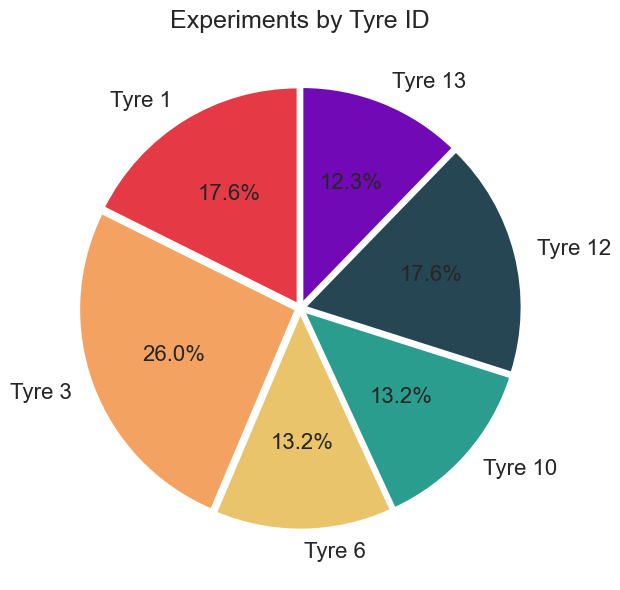

In [11]:
# Tyre distribution pie chart
pdf = (
    files_df.group_by("tyre_ID")
    .agg(pl.col("file_path").n_unique().alias("experiments"))
    .sort("tyre_ID")
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(8, 6))
colors = [TYRE_COLORS.get(t, "#95a5a6") for t in pdf["tyre_ID"]]

ax.pie(
    pdf["experiments"],
    labels=[f"Tyre {t}" for t in pdf["tyre_ID"]],
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=[0.02] * len(pdf),
    shadow=False,
    wedgeprops={"edgecolor": "white", "linewidth": 2},
    textprops={"fontsize": 16},
)

ax.set_title("Experiments by Tyre ID", fontsize=18)
plt.tight_layout()
plt.savefig(ROOT_DIR / "plots" / "experiments_per_tyre_id_pie.pdf", dpi=300)

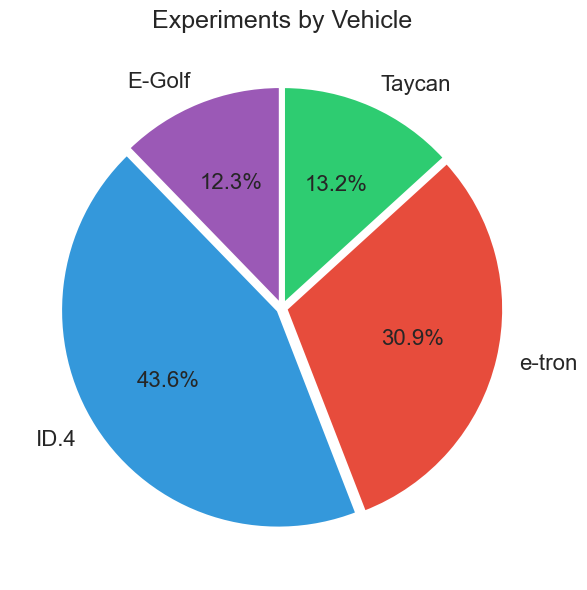

In [12]:
# Pie chart of experiments by Vehicle
pdf = (
    files_df.group_by("vehicle")
    .agg(pl.col("file_path").n_unique().alias("experiments"))
    .sort("vehicle")
    .to_pandas()
)

fig, ax = plt.subplots(figsize=(8, 6))
colors = [VEHICLE_COLORS.get(v, "#95a5a6") for v in pdf["vehicle"]]

# Clean vehicle names for display
clean_labels = [v.split(" ", 1)[1] if " " in v else v for v in pdf["vehicle"]]

ax.pie(
    pdf["experiments"],
    labels=clean_labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=[0.02] * len(pdf),
    shadow=False,
    wedgeprops={"edgecolor": "white", "linewidth": 2},
    textprops={"fontsize": 16},
)

ax.set_title("Experiments by Vehicle", fontsize=18)
plt.tight_layout()
plt.savefig(ROOT_DIR / "plots" / "experiments_per_vehicle_pie.pdf", dpi=300)

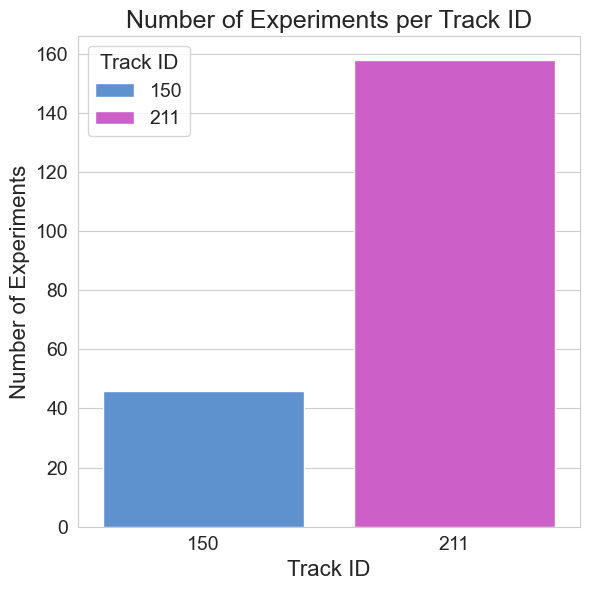

In [13]:
# Experiments per Track ID
tracks_cnt = files_df.group_by("track_ID").agg(pl.len().alias("count"))
ax = plt.subplots(figsize=(6, 6))[1]
fig = sns.barplot(tracks_cnt, x="track_ID", y="count", hue="track_ID", ax=ax, palette=TRACK_COLORS)
fig.set_xlabel("Track ID", fontsize=16)
fig.set_ylabel("Number of Experiments", fontsize=16)
fig.set_title("Number of Experiments per Track ID", fontsize=18)
fig.legend(title="Track ID", fontsize=14, title_fontsize=15)
fig.tick_params(axis="both", labelsize=14)
fig.xaxis.label.set_text("Track ID")
fig.yaxis.label.set_text("Number of Experiments")
plt.tight_layout()
plt.savefig(ROOT_DIR / "plots" / "experiments_per_track_id.pdf", dpi=300)

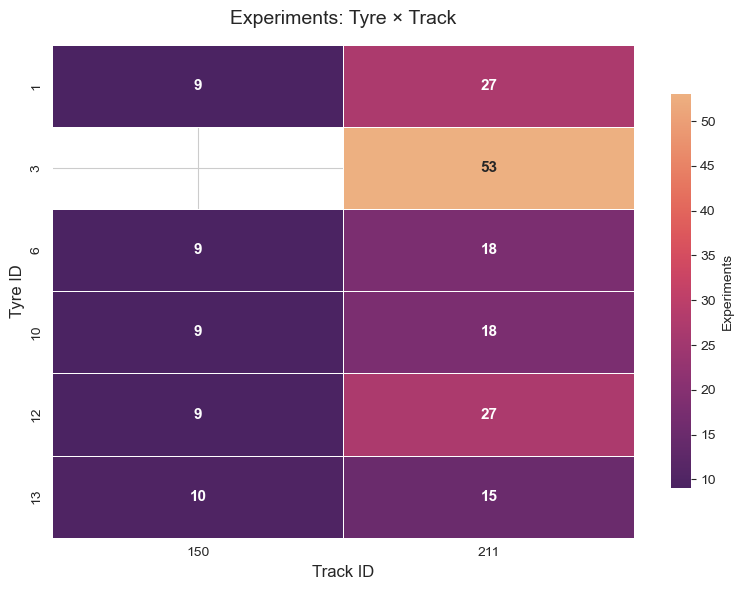

In [14]:
# Heatmap of Tyre × Track experiments
pdf = (
    files_df.group_by(["tyre_ID", "track_ID"])
    .agg(pl.col("file_path").n_unique().alias("experiments"))
    .to_pandas()
)

pivot_data = pdf.pivot(index="tyre_ID", columns="track_ID", values="experiments")

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    pivot_data,
    annot=True,
    fmt=".0f",
    cmap="flare_r",
    ax=ax,
    cbar_kws={"label": "Experiments", "shrink": 0.8},
    annot_kws={"fontsize": 11, "fontweight": "bold"},
    linewidths=0.5,
    linecolor="white",
)
ax.set_xlabel("Track ID", fontsize=12)
ax.set_ylabel("Tyre ID", fontsize=12)
ax.set_title("Experiments: Tyre × Track", fontsize=14, pad=15)
plt.tight_layout()
plt.savefig(ROOT_DIR / "plots" / "heatmap_experiments.pdf", dpi=300)

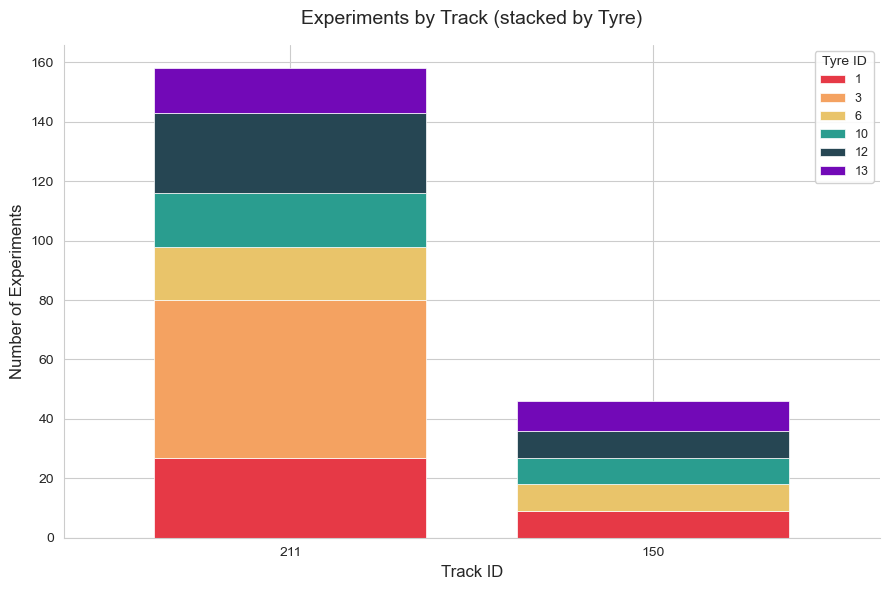

In [15]:
# Stacked bar chart of experiments by Track, colored by Tyre ID
pdf = (
    files_df.group_by(["track_ID", "tyre_ID"])
    .agg(pl.col("file_path").n_unique().alias("experiments"))
    .to_pandas()
)

pivot_data = pdf.pivot(index="track_ID", columns="tyre_ID", values="experiments").fillna(0)

# Sort by total experiments
pivot_data["total"] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values("total", ascending=False).drop(columns="total")

fig, ax = plt.subplots(figsize=(9, 6))

# Get colors for each tyre column
colors = [TYRE_COLORS.get(int(col), "#95a5a6") for col in pivot_data.columns]

pivot_data.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=colors,
    width=0.75,
    edgecolor="white",
    linewidth=0.5,
)

ax.set_xlabel("Track ID", fontsize=12)
ax.set_ylabel("Number of Experiments", fontsize=12)
ax.set_title("Experiments by Track (stacked by Tyre)", fontsize=14, pad=15)
ax.legend(
    title="Tyre ID",
    loc="upper right",
    fontsize=9,
    title_fontsize=10,
    framealpha=0.9,
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(ROOT_DIR / "plots" / "experiments_per_track_stacked_by_tyre_bar.pdf", dpi=300)

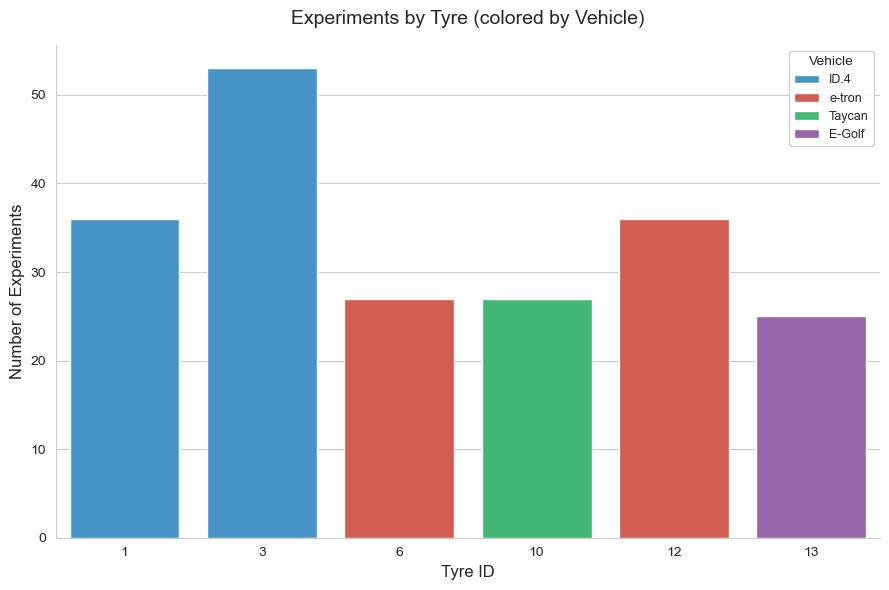

In [16]:
# Bar chart of experiments by Tyre, colored by vehicle type"""
pdf = (
    files_df.group_by(["tyre_ID", "vehicle"])
    .agg(pl.col("file_path").n_unique().alias("experiments"))
    .sort("experiments", descending=True)
)

fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    data=pdf,
    x="tyre_ID",
    y="experiments",
    hue="vehicle",
    palette=VEHICLE_COLORS,
    dodge=False,
    ax=ax,
    edgecolor="white",
    linewidth=1,
)

ax.set_xlabel("Tyre ID", fontsize=12)
ax.set_ylabel("Number of Experiments", fontsize=12)
ax.set_title("Experiments by Tyre (colored by Vehicle)", fontsize=14, pad=15)

# Clean legend labels
handles, labels = ax.get_legend_handles_labels()
clean_labels = [lab.split(" ", 1)[1] if " " in lab else lab for lab in labels]
ax.legend(
    handles,
    clean_labels,
    title="Vehicle",
    loc="upper right",
    fontsize=9,
    title_fontsize=10,
    framealpha=0.9,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(ROOT_DIR / "plots" / "experiments_per_tyre_id_bar.pdf", dpi=300)

In [133]:
def print_dataset_summary(df):
    """Print dataset summary statistics"""
    print("=" * 45)
    print("           DATASET SUMMARY")
    print("=" * 45)
    print(f"  Total Rows:          {len(df):,}")
    print(f"  Unique Variables:    {df['variable_name'].n_unique()}")
    print(f"  Unique Experiments:  {df['file_path'].n_unique()}")
    print()
    print(f"  Vehicles:  {df['vehicle'].n_unique()}")
    print(f"  Tyres:     {df['tyre_ID'].n_unique()}")
    print(f"  Tracks:    {df['track_ID'].n_unique()}")
    print()
    print("  Sample Rates:")
    print(f"    Min:   {df['sample_rate'].min()} Hz")
    print(f"    Max:   {df['sample_rate'].max()} Hz")
    print(f"    Mean:  {df['sample_rate'].mean():.1f} Hz")
    print()
    print("  Date Range:")
    print(f"    From:  {df['date'].min()}")
    print(f"    To:    {df['date'].max()}")
    print("=" * 45)


print_dataset_summary(files_df_expanded)

           DATASET SUMMARY
  Total Rows:          15,659
  Unique Variables:    139
  Unique Experiments:  204

  Vehicles:  4
  Tyres:     6
  Tracks:    2

  Sample Rates:
    Min:   142.85714285714286 Hz
    Max:   71999.99999999988 Hz
    Mean:  8201.9 Hz

  Date Range:
    From:  2025-07-11 09:39:41
    To:    2025-09-29 17:28:02


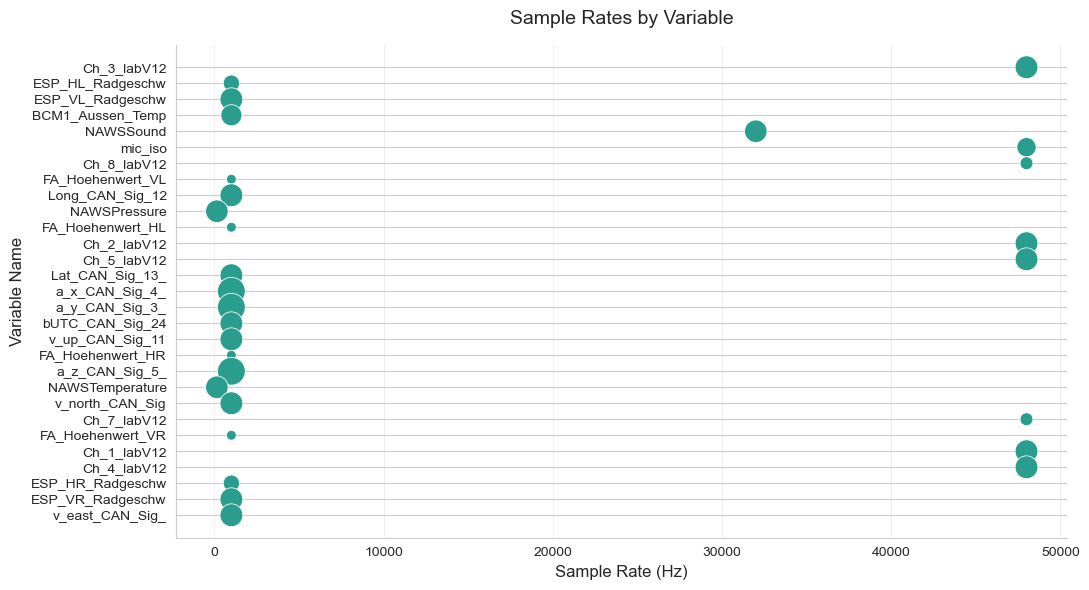

In [ ]:
def plot_sample_rate_by_variable(df):
    """Plot sample rates for different variables"""
    pdf = (
        df.group_by(["variable_name", "sample_rate"])
        .agg(pl.len().alias("count"))
        .filter(pl.col("sample_rate").is_not_null())
        .to_pandas()
    )

    fig, ax = plt.subplots(figsize=(11, 6))

    sns.scatterplot(
        data=pdf,
        x="sample_rate",
        y="variable_name",
        size="count",
        sizes=(50, 400),
        # alpha=0.7,
        ax=ax,
        color="#2a9d8f",
        legend=False,
    )

    ax.set_xlabel("Sample Rate (Hz)", fontsize=12)
    ax.set_ylabel("Variable Name", fontsize=12)
    ax.set_title("Sample Rates by Variable", fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    return fig


fig = plot_sample_rate_by_variable(df=files_df_expanded_relevant)

## Recording durations & channel length analysis
Investigate recording durations across channels, vehicles, tracks and tyres. This is useful to identify long vs short recordings, detect truncated files, and choose consistent durations for modeling or further preprocessing.

In [49]:
# Check the distribution of recording lengths (ignoring the ir images)
recording_lengths_1d = files_df_expanded_relevant.filter(
    pl.col("variable_shape").list.len() == 2
).with_columns(
    (pl.col("variable_shape").list.last() / pl.col("sample_rate")).alias("recording_duration_s"),
)

df = (
    recording_lengths_1d.group_by("file_path")
    .agg(
        pl.struct(
            [
                pl.col("variable_name"),
                pl.col("recording_duration_s"),
            ]
        ).alias("var_durations"),
        pl.col("recording_duration_s").mean().alias("mean_duration"),
    )
    .sort("mean_duration", descending=True)
    .select(pl.exclude("mean_duration"))
)

for row in df.iter_rows(named=True):
    print(f"File: {row['file_path']}")
    s = ""
    for var in row["var_durations"]:
        s += f"{var['variable_name']}: {var['recording_duration_s']:.1f}s, "
    print(f"Durations (s): {s}")
    print("-" * 40)

File: /Users/moritzfeik/Developer/ROAR/data_cleaned/track150/04_E-Golf/tyre13/track150_E-Golf_tyre13_meas2_2p5_1_2025-09-26_15-26-16.h5
Durations (s): BCM1_Aussen_Temp: 19.5s, Ch_1_labV12: 19.5s, Ch_2_labV12: 19.5s, Ch_3_labV12: 19.5s, Ch_4_labV12: 19.5s, Ch_5_labV12: 19.5s, Ch_7_labV12: 19.5s, Ch_8_labV12: 19.5s, ESP_HL_Radgeschw: 19.5s, ESP_HR_Radgeschw: 19.5s, ESP_VL_Radgeschw: 19.5s, ESP_VR_Radgeschw: 19.5s, Lat_CAN_Sig_13_: 19.5s, Long_CAN_Sig_12: 19.5s, NAWSPressure: 19.3s, NAWSSound: 19.3s, NAWSTemperature: 19.3s, a_x_CAN_Sig_4_: 19.5s, a_y_CAN_Sig_3_: 19.5s, a_z_CAN_Sig_5_: 19.5s, bUTC_CAN_Sig_24: 19.5s, mic_iso: 8.6s, v_east_CAN_Sig_: 19.5s, v_north_CAN_Sig: 19.5s, v_up_CAN_Sig_11: 19.5s, 
----------------------------------------
File: /Users/moritzfeik/Developer/ROAR/data_cleaned/track150/04_E-Golf/tyre13/track150_E-Golf_tyre13_meas3_2p5_1_2025-09-26_15-28-48.h5
Durations (s): BCM1_Aussen_Temp: 15.8s, Ch_1_labV12: 15.8s, Ch_2_labV12: 15.8s, Ch_3_labV12: 15.8s, Ch_4_labV12: 15

In [137]:
# mean recording duration by channel type
df.group_by("channel_type").agg(pl.col("recording_duration_s").mean())

channel_type,recording_duration_s
str,f64
"""other_channels""",5.361372
"""mic_iso""",5.853528


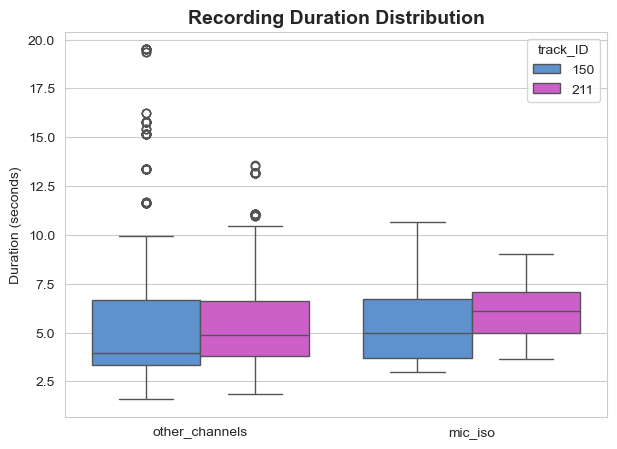

In [125]:
df = recording_lengths_1d.with_columns(
    pl.when(pl.col("variable_name") == "mic_iso")
    .then(pl.lit("mic_iso"))
    .otherwise(pl.lit("other_channels"))
    .alias("channel_type")
)

sns.boxplot(
    data=df.to_pandas(),
    x="channel_type",
    y="recording_duration_s",
    hue="track_ID",
    palette=TRACK_COLORS,
)
plt.title("Recording Duration Distribution", fontsize=14, fontweight="bold")
plt.ylabel("Duration (seconds)")
plt.xlabel("")
plt.savefig(
    ROOT_DIR / "plots" / "recording_duration_boxplot_by_channel_type.pdf",
    dpi=300,
    bbox_inches="tight",
)

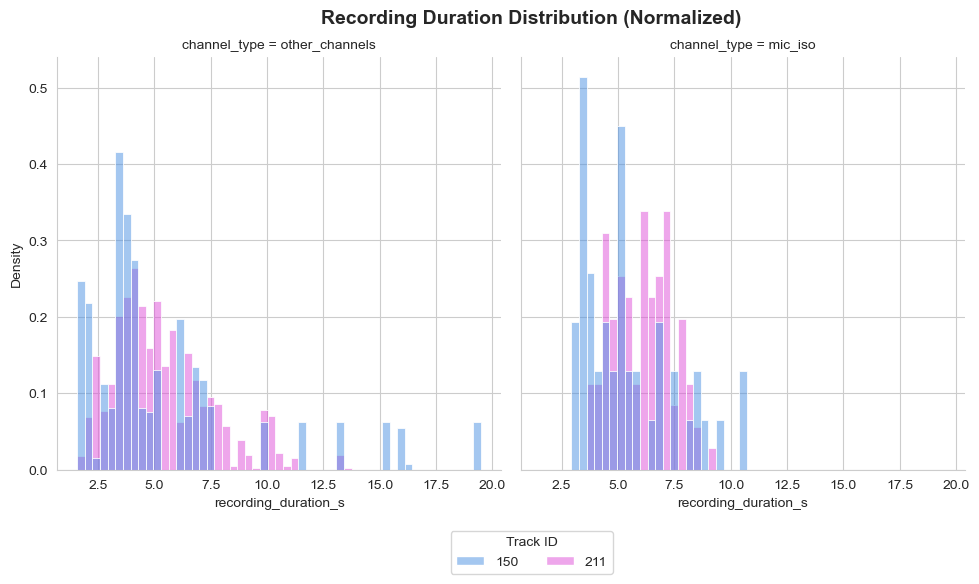

In [ ]:
fig = sns.displot(
    data=df.to_pandas(),
    x="recording_duration_s",
    col="channel_type",
    hue="track_ID",
    palette=TRACK_COLORS,
    stat="density",
    common_norm=False,
)

sns.move_legend(
    fig,
    loc="upper center",
    title="Track ID",
    bbox_to_anchor=(0.5, 0.00),
    ncol=3,
    frameon=True,
)

fig.figure.suptitle(
    "Recording Duration Distribution (Normalized)", fontsize=14, fontweight="bold", y=1.03
)
plt.savefig(
    ROOT_DIR / "plots" / "recording_duration_distribution_by_channel_type.pdf",
    dpi=300,
    bbox_inches="tight",
)

In [135]:
# More statistics per channel type and track ID
df.group_by("channel_type", "track_ID").agg(
    pl.col("recording_duration_s").mean().alias("mean_recording_duration_s"),
    pl.col("recording_duration_s").std().alias("std_recording_duration_s"),
)

channel_type,track_ID,mean_recording_duration_s,std_recording_duration_s
str,i64,f64,f64
"""mic_iso""",211,6.05826,1.307643
"""mic_iso""",150,5.386203,2.067237
"""other_channels""",150,5.439352,3.862767
"""other_channels""",211,5.337786,2.176081


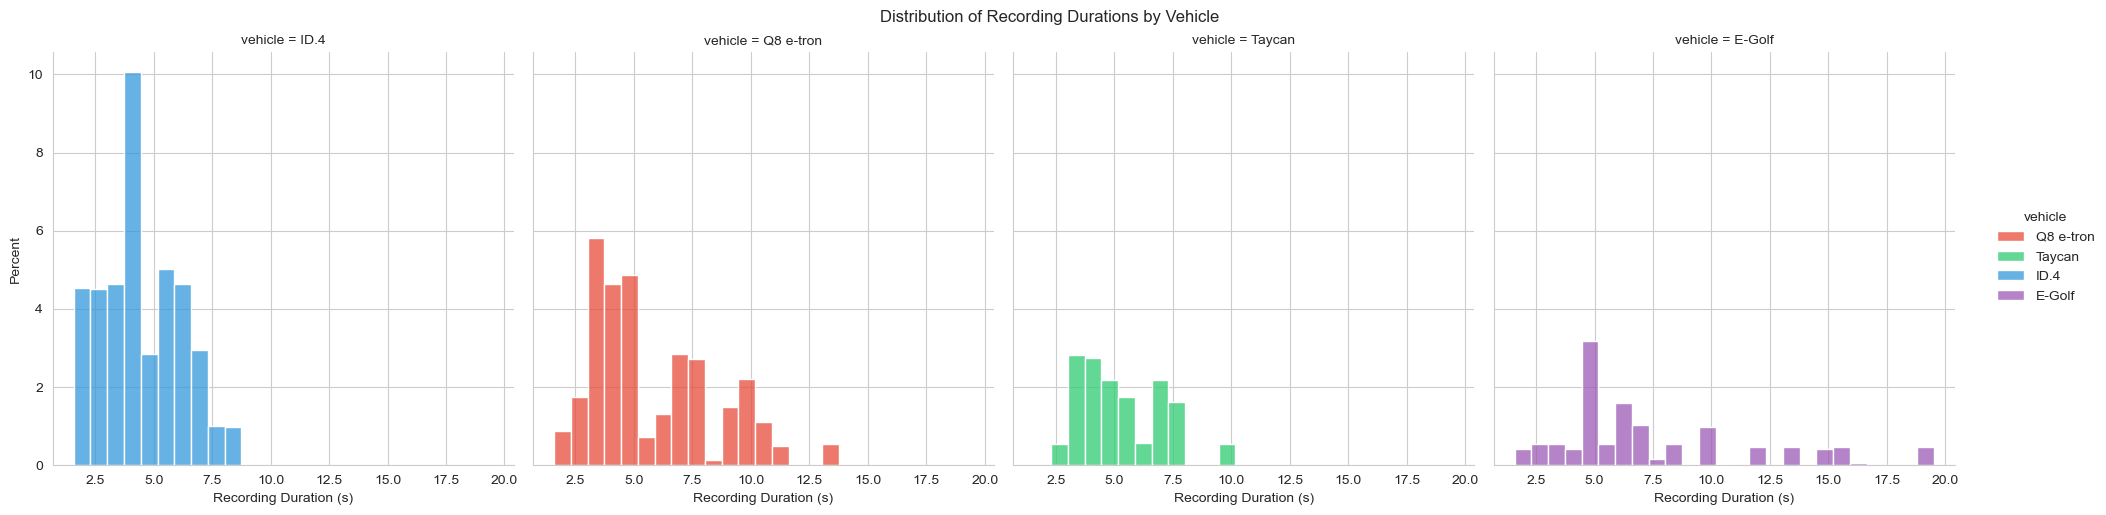

In [126]:
# Plot histogram of recording durations (seconds) using seaborn (linear scale only)
fig = sns.displot(
    data=recording_lengths_1d.to_pandas(),
    x="recording_duration_s",
    col="vehicle",
    # Hue options
    hue="vehicle",
    multiple="stack",
    palette=VEHICLE_COLORS,
    col_order=ALL_VEHICLES,
    # hist options
    kind="hist",
    kde=False,
    bins=25,
    stat="percent",
)
fig.set_axis_labels("Recording Duration (s)", None)
plt.suptitle("Distribution of Recording Durations by Vehicle", y=1.02)
plt.savefig(ROOT_DIR / "plots" / "distribution_durations_per_vehicle.pdf", dpi=300)

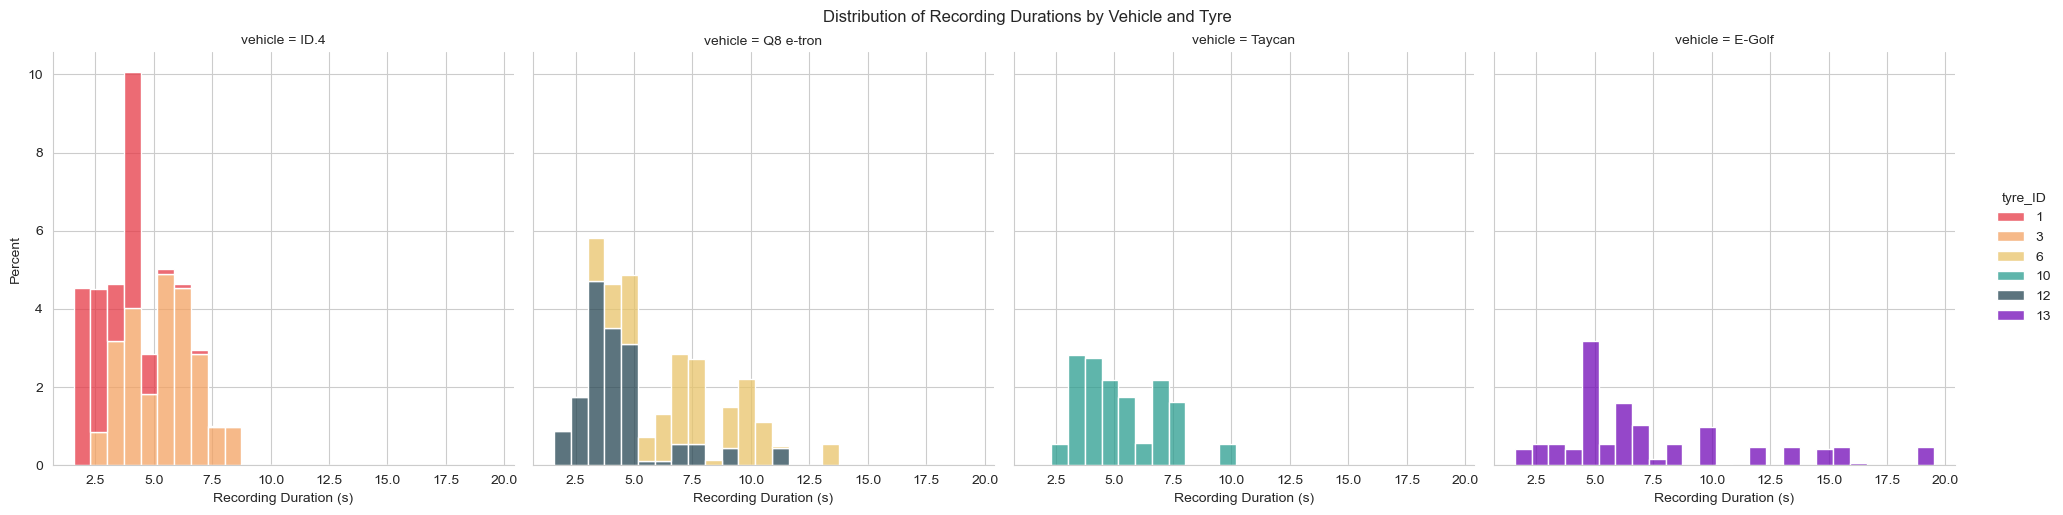

In [127]:
fig = sns.displot(
    data=recording_lengths_1d.to_pandas(),
    x="recording_duration_s",
    col="vehicle",
    hue="tyre_ID",
    col_wrap=4,
    palette=TYRE_COLORS,
    kind="hist",
    kde=False,
    bins=25,
    multiple="stack",
    stat="percent",
    col_order=ALL_VEHICLES,
)
fig.set_axis_labels("Recording Duration (s)", None)
plt.suptitle("Distribution of Recording Durations by Vehicle and Tyre", y=1.02)
plt.savefig(ROOT_DIR / "plots" / "distribution_durations_per_vehicle_and_tyre.pdf", dpi=300)

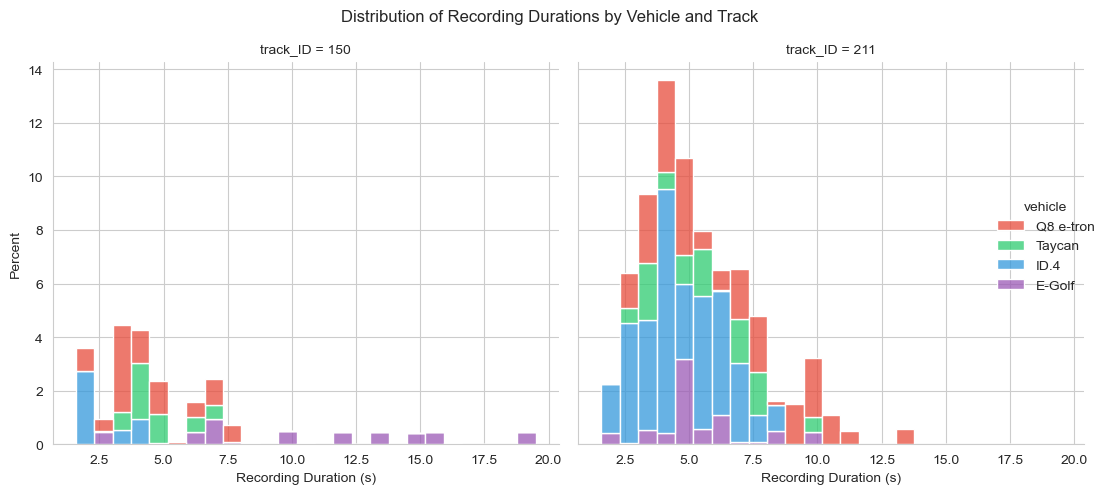

In [136]:
fig = sns.displot(
    data=recording_lengths_1d.to_pandas(),
    x="recording_duration_s",
    col="track_ID",
    hue="vehicle",
    col_wrap=2,
    palette=VEHICLE_COLORS,
    kind="hist",
    kde=False,
    bins=25,
    multiple="stack",
    stat="percent",
)
fig.set_axis_labels("Recording Duration (s)", None)
plt.suptitle("Distribution of Recording Durations by Vehicle and Track")
plt.tight_layout()
# plt.savefig(ROOT_DIR / "plots" / "distribution_durations_per_vehicle_and_tyre.pdf", dpi=300)